In [4]:
import torch
import random
import torch.nn.functional as F
from matplotlib import pyplot as plt
%matplotlib inline

# Dataset

In [2]:
with open('names.txt', 'r') as f:
    names = f.read().split()
names[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
chars = sorted(set(''.join(names)))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(stoi)
print(itos)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
def build_dataset(names):
    block_size = 3
    X, Y = [], []
    for name in names:
        context = [0] * block_size
        for ch in name + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.shuffle(names)
n1 = int(0.8 * len(names)) # 80% for training
n2 = int(0.9 * len(names)) # 10% for validation and same for testing

Xtr, Ytr = build_dataset(names[:n1])
Xdev, Ydev = build_dataset(names[n1:n2])
Xte, Yte = build_dataset(names[n2:])

torch.Size([182497, 3]) torch.Size([182497])
torch.Size([22784, 3]) torch.Size([22784])
torch.Size([22865, 3]) torch.Size([22865])


# Model

In [9]:
# two layer MLP
C = torch.randn((27,2)) # random vectors to represent the vocabulary
W1 = torch.randn((6, 100))
b1 = torch.randn(100)
W2 = torch.randn((100, 27))
b2 = torch.randn(27)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
sum(p.nelement() for p in parameters)

3481

# Training

## Choose a learning rate

In [10]:
# instead of examining the space torch.linspace(0.001, 1, 1000)
# of learning rates linearlly, we will examine it exponentially
lrs = torch.linspace(-3, 0, 1000)
lre = 10**lrs

In [11]:
all_lr, all_loss = [], []
for i in range(1000):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (32,)) # choose 32 training example
    
    # forward pass
    emb = C[Xtr[ix]] # (32x3x2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32x6) @ (6x100) + (100) --> (32x100)
    logits = h @ W2 + b2 # (32x100) @ (100x27) + (27) --> (32x27)
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update the parameters
    lr = lre[i]
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    all_loss.append(loss.item())
    all_lr.append(lrs[i])
    
print(loss.item())

7.941112995147705


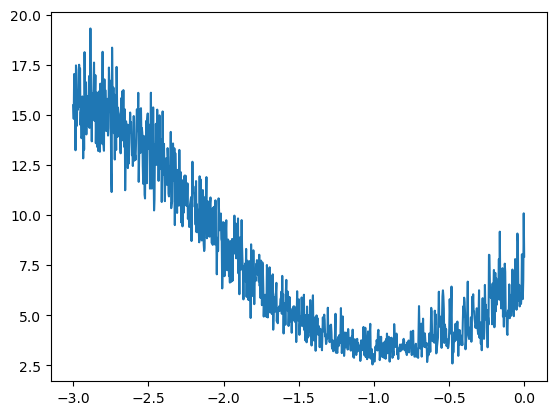

In [12]:
plt.plot(all_lr, all_loss)

It seems like $10^{-1}$ is a good learning rate

## Training

In [13]:
# reinitialize the parameters
C = torch.randn((27,2))
W1 = torch.randn((6, 100))
b1 = torch.randn(100)
W2 = torch.randn((100, 27))
b2 = torch.randn(27)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
sum(p.nelement() for p in parameters)

3481

In [14]:
all_steps = []
all_loss = []

In [15]:
for i in range(20000):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb = C[Xtr[ix]] # (32x3x2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32x6) @ (6x100) + (100) --> (32x100)
    logits = h @ W2 + b2 # (32x100) @ (100x27) + (27) --> (32x27)
    #---------------------------------------------------------
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(25), Y].log().mean()
    # This is better for more efficient forward and backward passes
    # and for better numerical behavior i.e. exp torch.tensor([100]).exp()
    loss = F.cross_entropy(logits, Ytr[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # some sort of learning rate schedular
    lr = .1 if i < 100000 else 0.01
    # update the parameters
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    all_steps.append(i)
    all_loss.append(loss.log10().item())
print(loss.item())

2.303152561187744


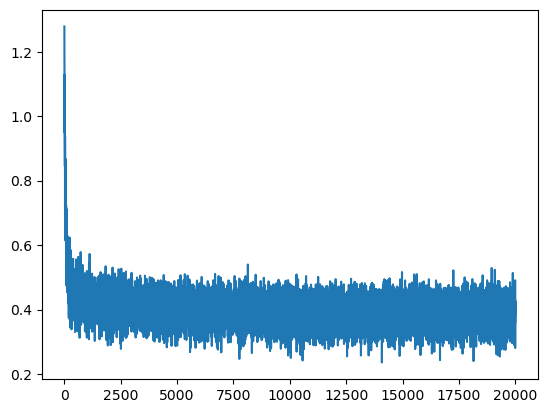

In [16]:
plt.plot(all_steps, all_loss)

# Evaluation

In [17]:
# training set loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print(f'Training loss is {loss}')

Training loss is 2.4348692893981934


In [18]:
# validation set loss
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(f'Validation loss is {loss}')

Validation loss is 2.453603744506836


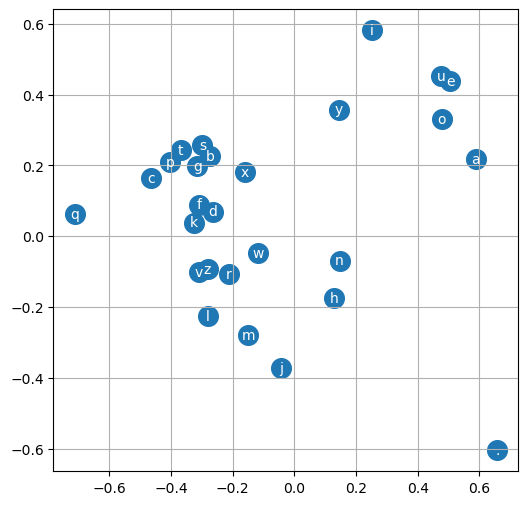

In [19]:
# only works for 2 or maybe three dimensional vectors
plt.figure(figsize=(6,6))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

# Sample from the model

In [21]:
block_size = 3
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, replacement=True).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

lacynh.
jojd.
nay.
nista.
lak.
sashia.
phiss.
breyy.
raqenjuw.
juga.
padia.
ryemi.
zore.
cer.
ser.
cucris.
was.
syat.
jayreca.
kalr.
